In [1]:
# Download the data from huggingface (https://huggingface.co/datasets/simbaswe/galah4/tree/main)
# and upload it to your google drive. Then, specify this directory here
DATA_PATH = "./"

In [4]:
# import the stuff you need. Pytorch is already installed on Google colab
import os
import time
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary
# import helper

In [5]:
spectra = np.load(f"{DATA_PATH}/spectra.npy")
spectra_length = spectra.shape[1]
# labels: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]
labels = np.load(f"{DATA_PATH}/labels.npy")
# We only use the three labels: t_eff, log_g, fe_h, SNR
labelNames = labelNames[-4:-1]
labels = labels[:, -4:-1]
n_labels = labels.shape[1]

In [6]:
# normalize the spectra
spectra = np.log(np.maximum(spectra, 0.2))

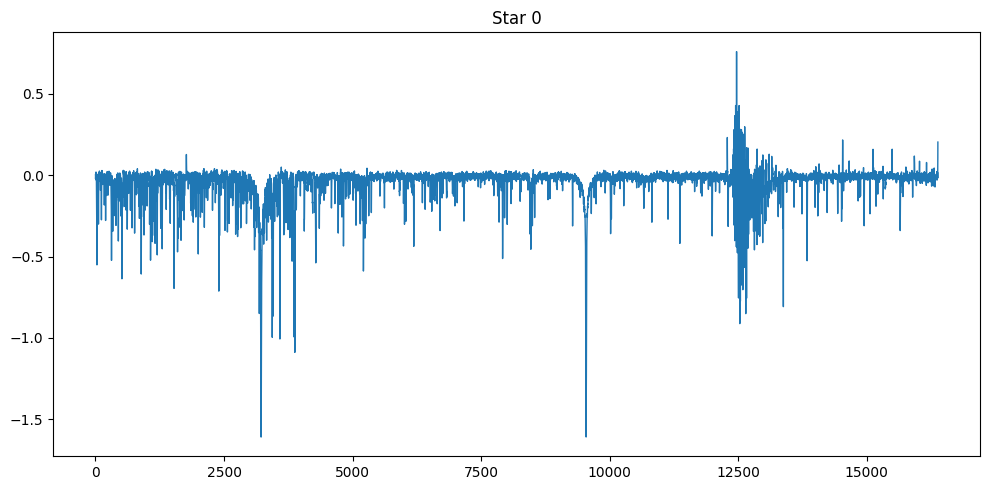

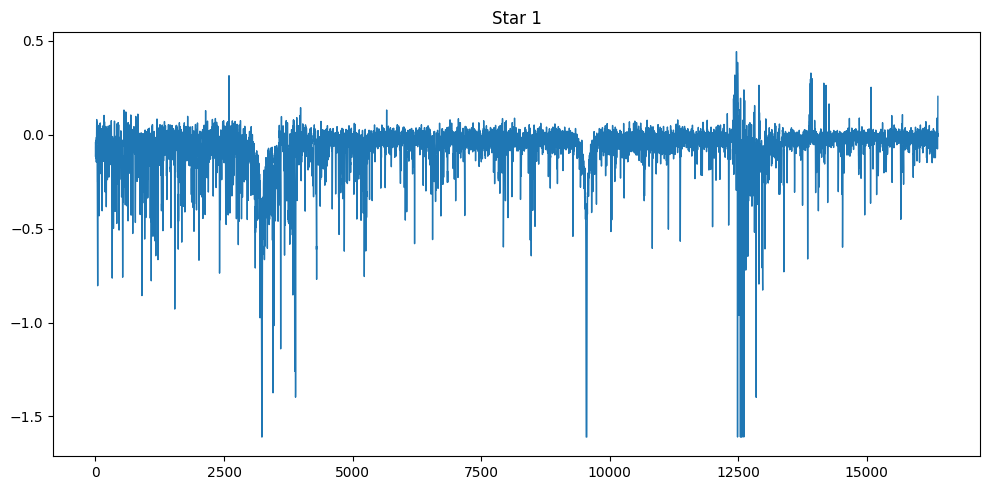

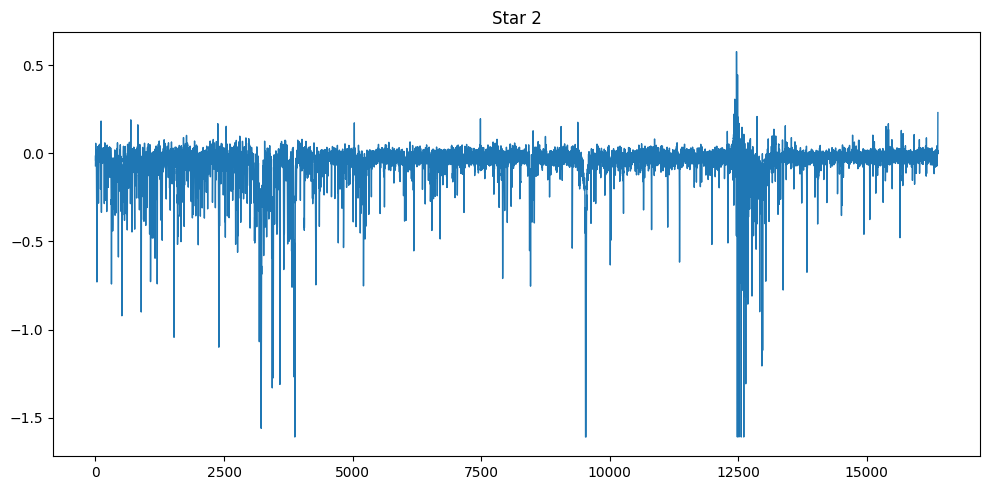

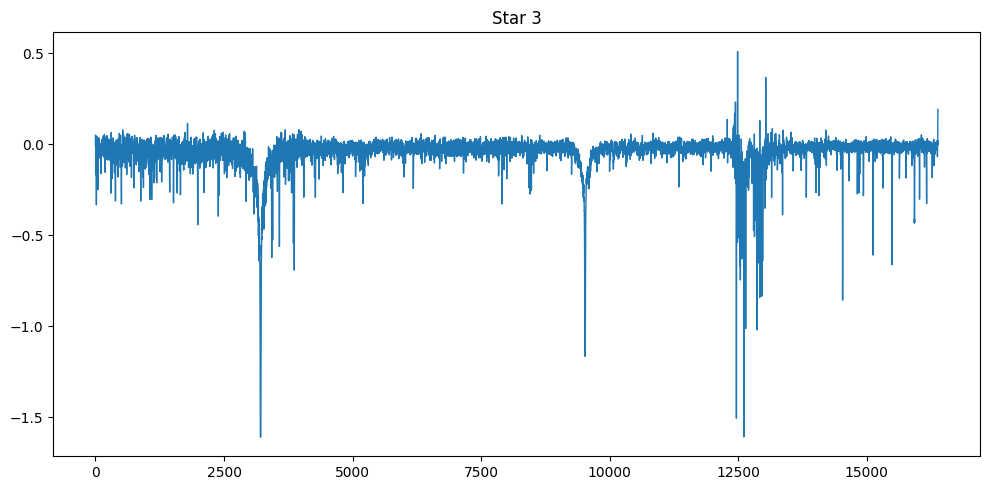

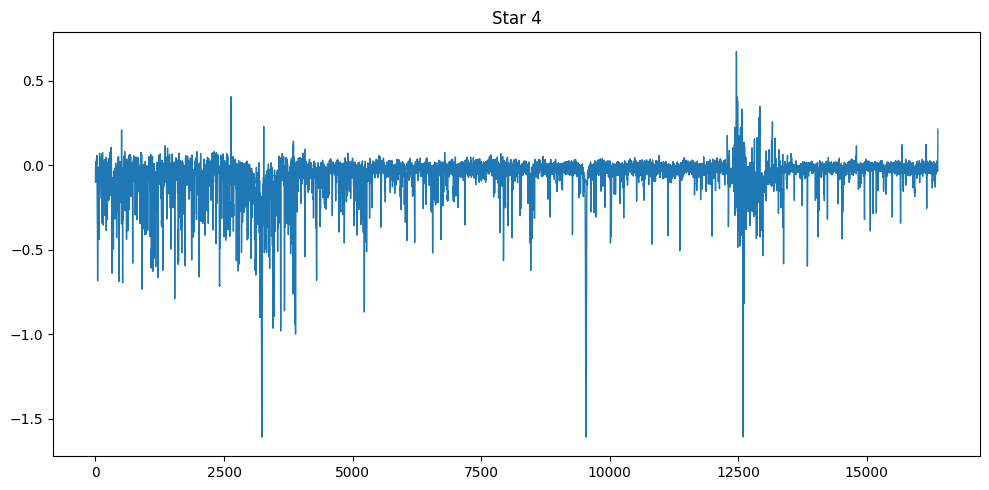

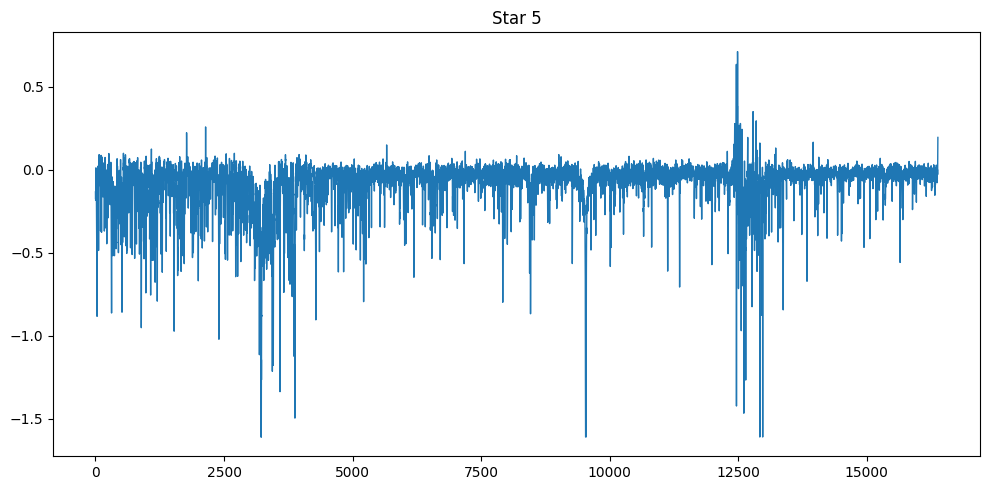

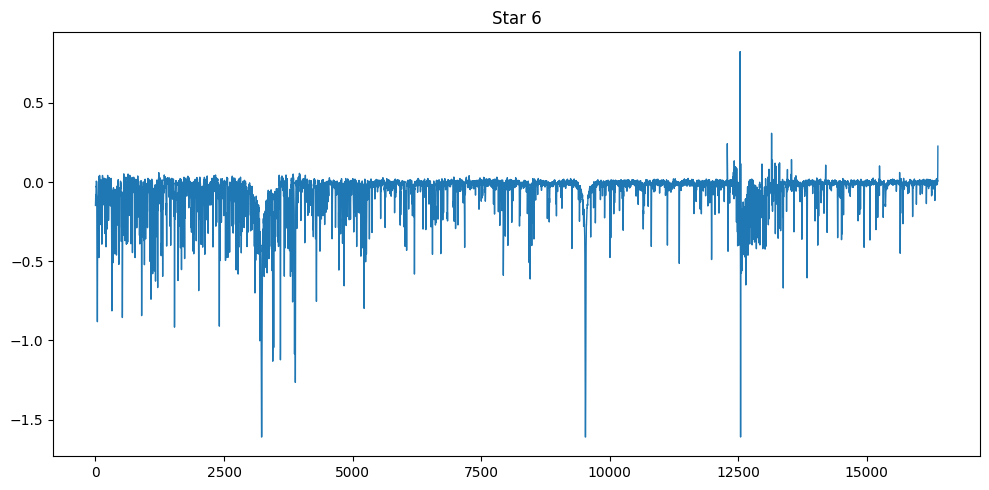

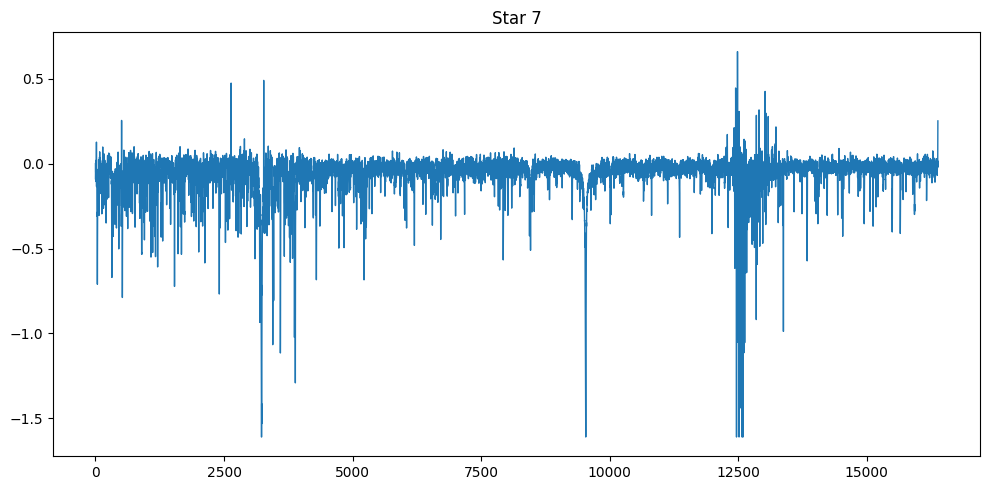

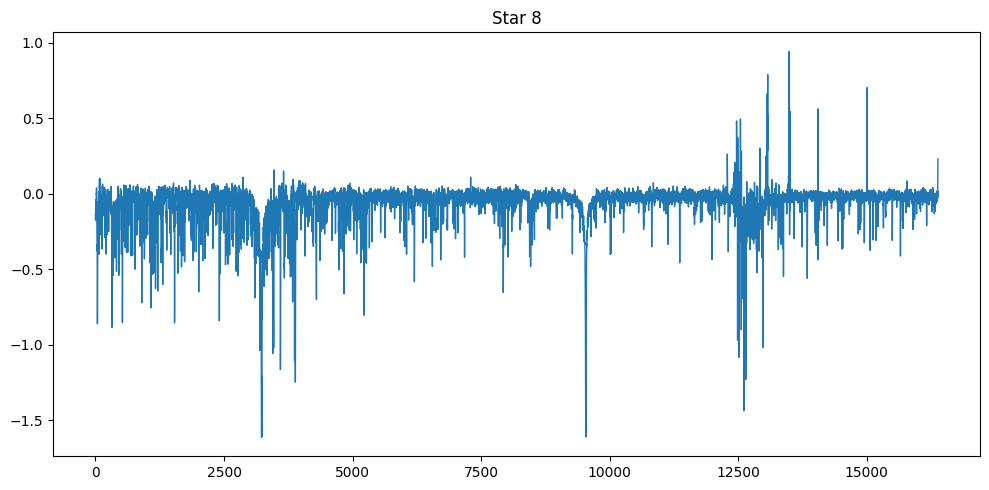

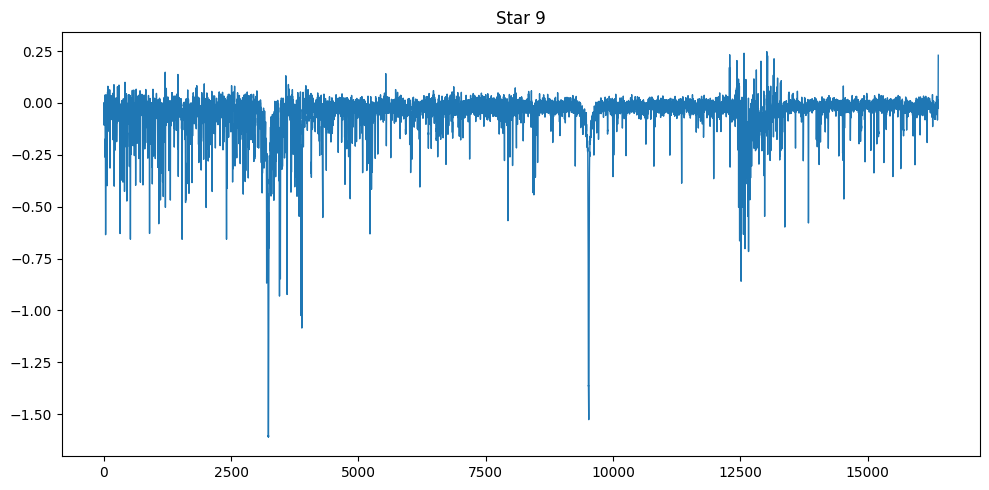

In [7]:
%matplotlib inline
# plot a few spectra
for i in range(10):
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))
  ax.plot(spectra[i], lw=1)
  ax.set_title(f"Star {i}")
  plt.tight_layout()

In [8]:
# Reshape spectra to (samples, channels, length)
spectra = spectra[:, np.newaxis, :]  # shape: (8914, 1, 16384)
print("New spectra shape:", spectra.shape)

New spectra shape: (8914, 1, 16384)


In [10]:
from sklearn.model_selection import train_test_split

spectra_train, spectra_val, labels_train, labels_val = train_test_split(
    spectra, labels, test_size=0.1, random_state=42
)

print("Train shape:", spectra_train.shape)
print("Val shape:", spectra_val.shape)


Train shape: (8022, 1, 16384)
Val shape: (892, 1, 16384)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch tensors
X_train = torch.tensor(spectra_train, dtype=torch.float32)
y_train = torch.tensor(labels_train, dtype=torch.float32)
X_val = torch.tensor(spectra_val, dtype=torch.float32)
y_val = torch.tensor(labels_val, dtype=torch.float32)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [12]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),  # compress to (batch, 64, 1)
            nn.Flatten(),             # (batch, 64)
            nn.Linear(64, 3)          # output 3 values: T_eff, log_g, Fe/H
        )

    def forward(self, x):
        return self.net(x)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# Loss function: Mean Squared Error (regression task)
criterion = nn.MSELoss()

# Optimiser: Adam with reasonable default LR
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [16]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/20 | Train Loss: 9532447.8611 | Val Loss: 7443806.9286
Epoch 2/20 | Train Loss: 2774627.4464 | Val Loss: 858697.8750
Epoch 3/20 | Train Loss: 464435.0192 | Val Loss: 183723.8527
Epoch 4/20 | Train Loss: 129998.4138 | Val Loss: 88505.8460
Epoch 5/20 | Train Loss: 84242.3240 | Val Loss: 80170.8686
Epoch 6/20 | Train Loss: 79345.7420 | Val Loss: 77559.0402
Epoch 7/20 | Train Loss: 77067.3722 | Val Loss: 75605.2882
Epoch 8/20 | Train Loss: 75578.3270 | Val Loss: 73918.1412
Epoch 9/20 | Train Loss: 73986.6989 | Val Loss: 72411.5167
Epoch 10/20 | Train Loss: 72437.4516 | Val Loss: 71174.9897
Epoch 11/20 | Train Loss: 71166.3477 | Val Loss: 71017.1071
Epoch 12/20 | Train Loss: 70350.6761 | Val Loss: 68844.6191
Epoch 13/20 | Train Loss: 69106.1338 | Val Loss: 67790.7626
Epoch 14/20 | Train Loss: 68079.8144 | Val Loss: 67012.2695
Epoch 15/20 | Train Loss: 67195.0963 | Val Loss: 65928.1203
Epoch 16/20 | Train Loss: 66073.1854 | Val Loss: 65158.7773
Epoch 17/20 | Train Loss: 65417.6547 | 

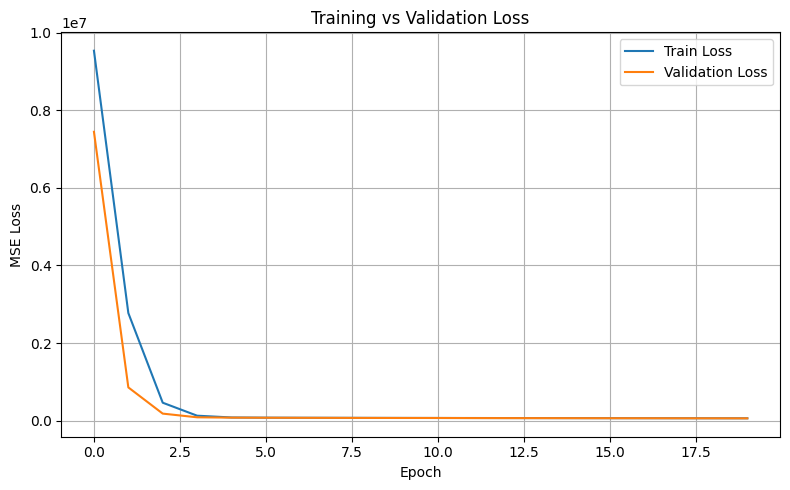

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


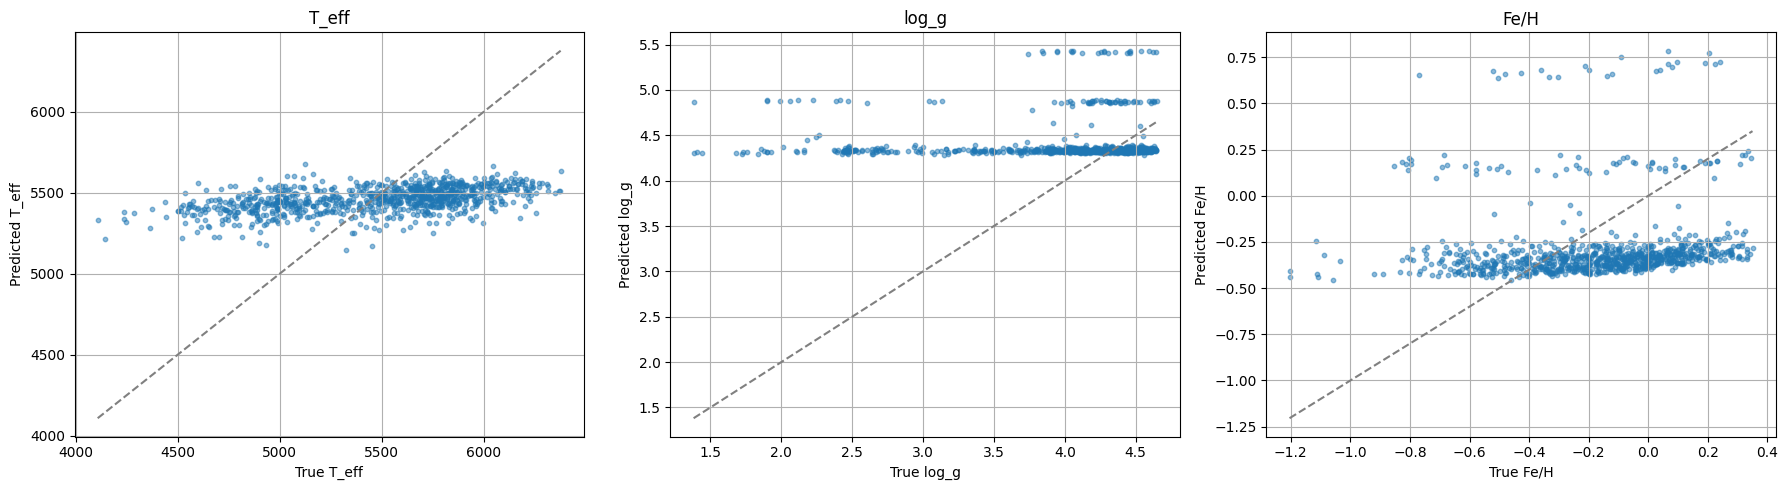

In [18]:
# Run model on entire val set
model.eval()
all_preds = []

with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        all_preds.append(preds)

# Stack all batches into a single array
preds = np.vstack(all_preds)
true = labels_val  # original NumPy labels for val set

label_names = ["T_eff", "log_g", "Fe/H"]

# Plot each label
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i in range(3):
    axs[i].scatter(true[:, i], preds[:, i], alpha=0.5, s=10)
    axs[i].set_xlabel(f"True {label_names[i]}")
    axs[i].set_ylabel(f"Predicted {label_names[i]}")
    axs[i].plot([true[:, i].min(), true[:, i].max()],
                [true[:, i].min(), true[:, i].max()],
                linestyle="dashed", color="gray")
    axs[i].set_title(label_names[i])
    axs[i].grid(True)

plt.tight_layout()
plt.show()
